**This notebook generates four feature variables (MPD, near_dist, leverage, caught_width), target variable (progress after caught), and censoring variable (last event), fits a CPH model.**

In [55]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.spatial import distance
from scipy.spatial import cKDTree
import math
from numpy import cov

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid", palette = 'dark')

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler

import get_data
import tackle_plot

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot(gameId, playId):
    game = get_data.game(gameId)
    play = get_data.play(gameId, playId)
    tracking = get_data.tracking(gameId, playId).reset_index()
    
    date = game['gameDate'].item()
    tacklers = get_data.tacklers(gameId, playId)
    carrier = play['ballCarrierId'].item()
    offense = play['possessionTeam'].item()
    defense = play['defensiveTeam'].item()
    down = play['down'].item()
    yardstogo = play['yardsToGo'].item()
    ablos = play['absoluteYardlineNumber'].item()    
    
    return tackle_plot.plot(tracking, date, tacklers, carrier, offense, defense, down, yardstogo, ablos)  

In [3]:
games_all = pd.read_csv('../rawdata/games.csv')
tackles_all = pd.read_csv('../rawdata/tackles.csv')
players_all = pd.read_csv('../rawdata/players.csv')
plays_all = pd.read_csv('../rawdata/plays.csv')

In [4]:
tracking_data = {}
for i in range(9):
    w = i + 1
    tracking_data[w] = pd.read_csv(f'../rawdata/tracking_week_{w}.csv')

### Prepare dataset

Dataset 'plays_tackle' was generated in 'data_overview', merged from play data and tackle data, only including 'pass short' play, with certain abnormal data removed. 

In [5]:
plays_tackle = pd.read_csv('../newdata/plays_tackle.csv')

In [6]:
plays_tackle.shape

(6596, 42)

- Check the plays which have multiple recorded tacklers.

In [7]:
plays_tackle[plays_tackle.duplicated(subset = ['gameId', 'playId'])].shape

(1572, 42)

In [8]:
duplicated_plays = plays_tackle[plays_tackle.duplicated(subset = ['gameId', 'playId'], keep = False)][
    ['gameId', 'playId', 'nflId', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']]

In [9]:
duplicated_plays.groupby(['gameId', 'playId'])[['tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].sum().value_counts()

tackle  assist  forcedFumble  pff_missedTackle
0.0     2.0     0.0           0.0                 420
1.0     0.0     0.0           1.0                 391
        1.0     0.0           0.0                 332
0.0     2.0     0.0           1.0                  61
1.0     1.0     0.0           1.0                  50
        0.0     0.0           2.0                  46
0.0     2.0     0.0           2.0                  16
1.0     0.0     0.0           3.0                  10
0.0     0.0     0.0           2.0                   9
1.0     1.0     1.0           0.0                   8
                0.0           2.0                   7
0.0     2.0     1.0           0.0                   5
1.0     0.0     1.0           1.0                   4
        1.0     0.0           3.0                   2
0.0     0.0     0.0           3.0                   1
1.0     0.0     0.0           4.0                   1
0.0     2.0     1.0           1.0                   1
2.0     1.0     1.0           0.0  

Multiple tackler records have two main categories: 1 tackler + 1 assist/1 pff_missedTackle, 2 assist. \
To simplify the analysis, I'll keep the first recorded tackler for each play.

In [10]:
plays_tackle = plays_tackle.drop_duplicates(subset = ['gameId', 'playId'], keep = 'first').reset_index(drop = True)

In [11]:
plays_tackle.shape

(5024, 42)

## Generate feature variables, target variable, and censoring variable

### Introduction

In this project, I'm applying the survival analysis method on the ball's survival duration from when it's caught in a pass to when it's 'dead'. Survival analysis was invented to analyze time-to-event data, specifically patients' survival during an observed period. Survival analysis methods are special for their abilities to deal with censored data --- for patients who were alive when the study ended, the minimum time they survived was known but the exact death time wouldn't be observed, those cases fall into one category of censored data.

- **Target event**

This analysis targets the occurrence of a dead ball caused by the defense team's tackling attempt/pressure, following a short pass completed by the offense team.

- **Survival duration**

It's not common to use survival analysis on distance-to-event data. I'd like to use this project as an experimental attempt by treating ball progress on the x-axis as the target variable. One concern is that this variable is not always increasing during the observed period like a time variable, which is typical for survival analysis. Given time, I'd like to further look into this difference and its meaning.

- **Censored data**

It makes sense to treat touchdown plays as right-censored data, as we know the minimum survival duration of the ball when the touchdown happens and the study (play) ends before we can observe the targeted event. However, how to treat out-of-bounds data is not so clear. Although some carriers were pushed out of bounds by the tackler which matches this analysis' purposes, some other carriers decided to step out for various reasons before the tackler got tightly close. The less pressure the carrier was under at the out-of-bounds moment, the more reasonable it was to treat the case as censored data. However, statistically the censoring data should be non-informative to avoid bias, which requires the reason for censoring is not related to the likelihood of the event occurring. No matter under which scenario the carrier decided to step out of bounds, the defense team's tackling attempts affected the decision. Therefore, in this analysis, I'm treating out-of-bounds data as targeted events instead of censored data.

### Feature variables

Like many survival analyses that focus on the patient treatments/conditions at the start of the study, I generated features mainly based on the play conditions when the ball is caught as the result of a short pass. The features include:

- **near_defender_MPD** 

'MPD (minimum possible distance)' - The minimum achievable distance between a defender and a carrier, calculated based on their current positions and velocities. A low value of MPD may indicate a good aim or good prediction from the defender, while a high value may indicate the carrier set himself free from the threat. The calculation equation is explained in 'calculate_minimum_distance'.
'near defender' - The current primary defender near the ball carrier at the caught moment. To simplify the analysis, I choose one primary defender to calculate MPD from for each play. This approach is relevant in pass plays, where the receiver/carrier is often in a one-on-one matchup with their marker, thereby justifying choosing one defender to analyze. Note that given more time, there is space to improve this approach.
To identify the primary defender, my first approach is to retrieve the tackler id from 'tackles' data. However, there is a risk of leaking later time information to the model which should analyze the caught moment, as the tackler id was recorded upon events that happened later. For example, if the recorded tackler is 20 yards away from the carrier at the caught moment, bringing in this data gives the model hidden information that the ball will likely survive the next few frames. In addition, the MPD of a tackler when he's 20 yards away from the carrier is not relevant.
Therefore, I calculate the distance between both the recorded tackler and the nearest defender to the carrier at the caught moment. If the tackler is not the nearest defender and is 8 yards farther from the carrier than the nearest defender, I choose the nearest defender as the primary defender to calculate MPD from. 8 is an arbitrary choice.

- **near_dist** 

'near_dist' - The distance between the carrier and the selected primary defender at the caught moment.

- **leverage**

'leverage' - Whether the primary defender has inner or outer leverage at the caught moment.

- **caught_width**

'caught_width' - The distance between the carrier to the sideline at the caught moment.

In [12]:
def standardize_tracking(tracking):
    """
    Standardize data so all plays are seen as played from left to right

    Parameters:
    df1 (DataFrame): tracking data of one selected play.
    Returns:
    df1 (DataFrame): standardized tracking data of one selected play.
    """
    tracking['x'] = 120-tracking['x']
    tracking['y'] = 53.3-tracking['y']  
    tracking['dir'] = (tracking['dir'] + 180) % 360
    tracking['o'] = (tracking['o'] + 180) % 360
    return tracking

In [13]:
def get_near_dist(target, points):
    """
    Finds the nearest point from 'target' to a set of 'points'.

    Parameters:
    target (np.ndarray): A numpy array [x, y].
    points (np.ndarray): A numpy array of points [[x1, y1], [x2, y2], ...].

    Returns:
    The distance to the nearest point and the index of that point in 'points'.
    """    
    tree = cKDTree(points)
    distance, index = tree.query(target)
    return distance, index

In [14]:
def speed_to_vector(s, diret):
    """
    Converts speed and direction into a 2D velocity vector.

    Parameters:
    s (float): Speed.
    diret (float): Direction in degrees (0-360).

    Returns:
    numpy.array: A 2D vector representing the speed and direction.
    """    
    dir_radians = math.radians(diret)
    theta = math.radians(90) - dir_radians

    x = round(s * math.cos(theta),2)
    y = round(s * math.sin(theta),2)
    return np.array([x, y])

In [15]:
def calculate_MPD(df1, df2):
    """
    Calculates the minimum distance between two moving objects, based on the initial positions and velocities 
    of the objects using data in df1 and df2.

    Parameters:
    df1 (DataFrame): A DataFrame containing 'x', 'y' (position coordinates), 
                     'dir' (direction), and 's' (speed) of the first object.
    df2 (DataFrame): A DataFrame containing 'x', 'y' (position coordinates), 
                     'dir' (direction), and 's' (speed) of the second object.

    Returns:
    float: The Minimum Possible Distance (MPD) between the two objects.
    """
    x_1, y_1, dir_1, s_1 = df1[['x', 'y', 'dir', 's']].iloc[0]
    x_2, y_2, dir_2, s_2 = df2[['x', 'y', 'dir', 's']].iloc[0] 
    V1 = speed_to_vector(s_1, dir_1)
    V2 = speed_to_vector(s_2, dir_2) 
    V_12 = V1-V2
    
    xy_1 = np.array([x_1, y_1])
    xy_2 = np.array([x_2, y_2])
    
    cross_product = np.linalg.det(np.array([V_12, xy_1 - xy_2]))
    V_12_abs = np.linalg.norm(V_12)
    MPD = np.abs(cross_product) / V_12_abs    
    
    return MPD

In [16]:
%%time
progress_data = []

for idx, row in plays_tackle.iterrows():
    gameId, playId = row['gameId'], row['playId']
    game_week = games_all[games_all['gameId'] == gameId]['week'].item()
    carrier = row['ballCarrierId']
    offense = row['possessionTeam']
    defense = row['defensiveTeam']
   
    tracking_w = tracking_data[game_week]
    tracking = tracking_w[(tracking_w['gameId'] == gameId) & (tracking_w['playId'] == playId)].reset_index(drop = True)
    if tracking.at[0, 'playDirection'] == 'left':
        tracking = standardize_tracking(tracking)

    # Get events and corresponding frameIds
    events = tracking[['frameId', 'event']].dropna(subset=['event']).drop_duplicates().sort_values(by = 'frameId')
    caught_frm = 6
    # Note the special case
    if gameId == 2022110608 and playId == 2351:
        caught_frm = 32
    lst_event = events.event.to_list()[-1]
    lst_event_frm = events.frameId.to_list()[-1]    
    
    # Extract data when the ball is caught and when the play ends
    caught_df = tracking[tracking['frameId'] == caught_frm]
    lst_df = tracking[tracking['frameId'] == lst_event_frm]    
    
    carrier_caught_df = caught_df[caught_df['nflId'] == carrier]
    carrier_caught_xy = carrier_caught_df[['x', 'y']].to_numpy()[0]
    
    # Calculate nearest defender distance to carrier    
    defense_caught_df = caught_df[caught_df['club'] == defense].reset_index(drop = True)
    defense_caught_xy = defense_caught_df[['x', 'y']].to_numpy()
    
    near_dist, index = get_near_dist(carrier_caught_xy, defense_caught_xy)
    near_defender = defense_caught_df.iloc[index]['nflId']
    
    # If recorded tackler exists and tackler distance - nearest defender distance < 8, use tackler as primary
    if not pd.isna(row['nflId']):    
        tackler = row['nflId']
        tackler_caught_df = caught_df[caught_df['nflId'] == tackler]
        tackler_caught_xy = tackler_caught_df[['x', 'y']].to_numpy()[0]  
        tackler_dist = math.dist(carrier_caught_xy, tackler_caught_xy)    
        
        if tackler_dist - near_dist < 8:
            near_defender = tackler          

    # Calculate MPD for the primary defender        
    near_defender_caught_df = caught_df[caught_df['nflId'] == near_defender]
    near_defender_caught_xy = near_defender_caught_df[['x', 'y']].to_numpy()[0]   
    
    near_defender_MPD = calculate_MPD(near_defender_caught_df, carrier_caught_df)

    # Calculate the ball's forward progress from caught moment to end moment
    ball_caught_x = caught_df[caught_df['displayName'] == 'football']['x'].item()
    ball_lst_x = lst_df[lst_df['displayName'] == 'football']['x'].item()    
    progress = ball_lst_x - ball_caught_x    
    
    # Get primary defender's leverage
    if abs(26.65 - carrier_caught_xy[1]) < abs(26.65 - near_defender_caught_xy[1]):
        leverage = 'outer'
    elif abs(26.65 - carrier_caught_xy[1]) > abs(26.65 - near_defender_caught_xy[1]):
        leverage = 'inner'     
    else:
        leverage = 'neither'
     
    # Get carrier's distance to sideline    
    if carrier_caught_xy[1] <= 26.65:
        caught_width = 26.65 - carrier_caught_xy[1]
    else: 
        caught_width = 53.3 - carrier_caught_xy[1]
    
    progress_data.append({'gameId': gameId, 'playId': playId, 'progress': progress, 'lst_event': lst_event,
                           'near_defender': near_defender, 'near_defender_MPD': near_defender_MPD,
                           'near_dist': near_dist, 'leverage': leverage, 'caught_width': caught_width, 
                           'caught_x': ball_caught_x})  

progress_df = pd.DataFrame(progress_data)

CPU times: total: 1min 30s
Wall time: 55.5 s


In [17]:
progress_df.shape

(5024, 10)

In [18]:
progress_df.head()

,gameId,playId,progress,lst_event,near_defender,near_defender_MPD,near_dist,leverage,caught_width,caught_x
0,2022100908,3537,2.340000,tackle,43306.0,0.318461,3.881714,inner,2.07,57.560001
1,2022091111,1148,2.779999,tackle,47843.0,0.831594,2.832137,outer,0.23,51.650002
2,2022103001,2165,9.760002,tackle,46205.0,3.444545,7.086353,inner,18.29,23.480000
3,2022092511,2903,6.030006,tackle,52527.0,2.751467,3.919005,inner,9.83,31.449997
4,2022091102,3336,0.739998,tackle,46077.0,0.735391,0.860930,inner,24.29,48.610001


## Variable exploration and transformation

- Check distribution

(-7.629997253417997, 72.9800033569331)

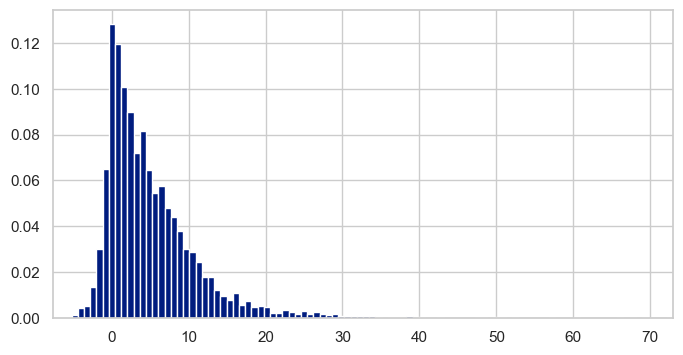

In [19]:
plt.figure(figsize=(8, 4))
plt.hist(progress_df.progress, bins=100, density=True)
plt.xlim(min(progress_df.progress), max(progress_df.progress))

- Check negative progress

In [20]:
progress_df[progress_df['progress'] < 0].shape

(682, 10)

(-7.629997253417997, 1.9899997711181072)

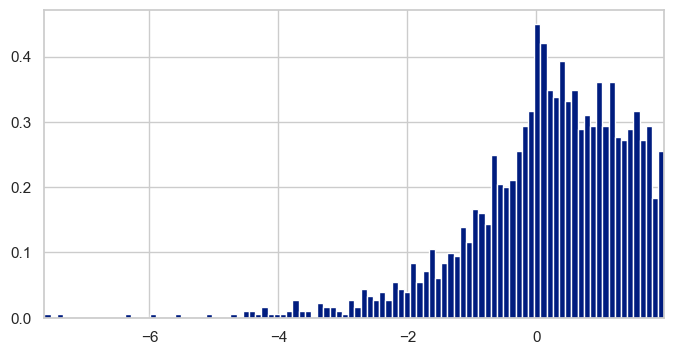

In [21]:
plt.figure(figsize=(8, 4))
plt.hist(progress_df[progress_df['progress'] < 2].progress, bins=100, density=True)
plt.xlim(min(progress_df[progress_df['progress'] < 2].progress), max(progress_df[progress_df['progress'] < 2].progress))

- concordance and transforming data

The most frequently used evaluation metric of survival models is the concordance index, which is defined as the ratio of correctly ordered (concordant) pairs to comparable pairs. Therefore, I'll transform the data with small values (including all the negative values) into a range between 0 and 1 while keeping their original order.

In [129]:
progress_df2 = progress_df.copy()

In [117]:
def scale_value(v, left_0, right_0, left_1, right_1):
    '''
    Scales a value from range [left_0, right_0] and to a new range [left_1, right_1].
    '''
    return left_1 + ((v - left_0) * (right_1 - left_1)) / (right_0 -left_0)

In [130]:
# Scale value between (0,0.8) to (0.5,0.8)
progress_df2['progress'] = progress_df2['progress'].apply(
    lambda x: scale_value(x, 0, 0.8, 0.5, 0.8) if x >=0 and x< 0.8 else x)

In [131]:
# reassign value < 0
progress_df2['progress'] = progress_df2['progress'].apply(lambda x: 0.1 if x < -1 else x)
progress_df2['progress'] = progress_df2['progress'].apply(lambda x: 0.2 if x < -0.3 else x)
progress_df2['progress'] = progress_df2['progress'].apply(lambda x: 0.4 if x < 0 else x)

Text(0.5, 1.0, 'Histogram')

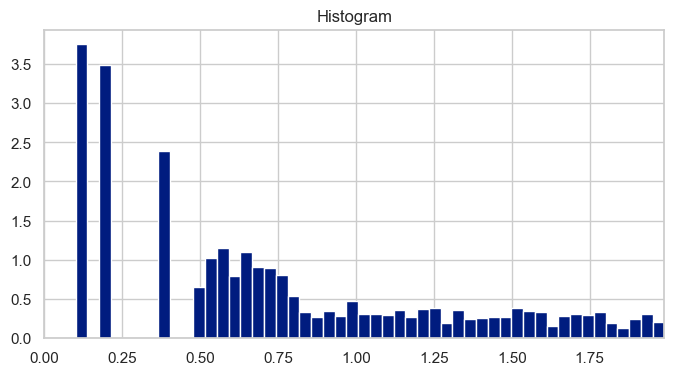

In [132]:
plt.figure(figsize=(8, 4))
plt.hist(progress_df2[progress_df2['progress'] < 2].progress, bins=50, density=True)
plt.xlim(0, max(progress_df2[progress_df2['progress'] < 2].progress))
plt.title('Histogram')

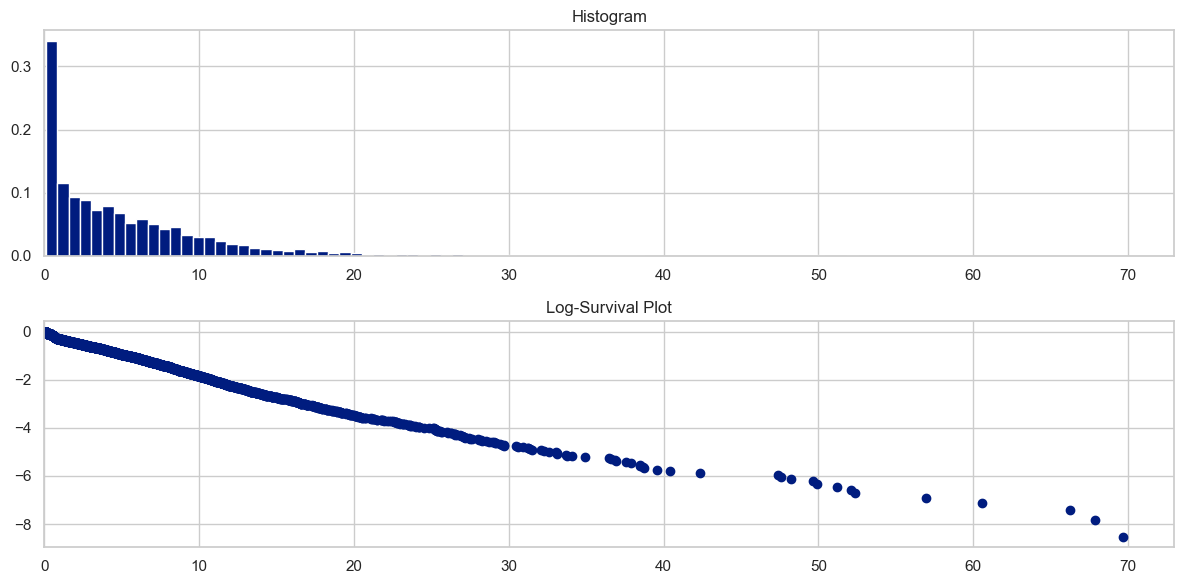

In [82]:
# Check distribution of all progress value
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.hist(progress_df2.progress, bins=100, density=True)
plt.xlim(0, max(progress_df2.progress))
plt.title('Histogram')

plt.subplot(2, 1, 2)
sorted_data = np.sort(progress_df2.progress)
survival = np.log(1 - np.arange(1, len(progress_df2.progress) + 1) / len(progress_df2.progress))
plt.plot(sorted_data, survival, 'o')
plt.title('Log-Survival Plot')
plt.xlim(0, max(progress_df2.progress))
plt.tight_layout()
plt.show()

The straight line indicates the progress value is close to an exponential distribution.

In [83]:
progress_df2['lst_event'].value_counts()

lst_event
tackle                      3761
out_of_bounds               1091
touchdown                    123
fumble                        45
fumble_defense_recovered       2
pass_outcome_caught            1
first_contact                  1
Name: count, dtype: int64

In [84]:
# Only touchdowns are treated as censored data
progress_df2['lst_event'] = progress_df2['lst_event'].apply(lambda x: 0 if x == 'touchdown' else 1)

In [85]:
progress_df2['leverage'].value_counts()

leverage
inner      3215
outer      1794
neither      15
Name: count, dtype: int64

In [86]:
# only 15 plays have both plays share the same y value, they are merged into 'outer category'
progress_df2['leverage'] = progress_df2['leverage'].apply(lambda x: 0 if x == 'inner' else 1)

In [87]:
progress_df2.head()

,gameId,playId,progress,lst_event,near_defender,near_defender_MPD,near_dist,leverage,caught_width,caught_x
0,2022100908,3537,2.340000,1,43306.0,0.318461,3.881714,0,2.07,57.560001
1,2022091111,1148,2.779999,1,47843.0,0.831594,2.832137,1,0.23,51.650002
2,2022103001,2165,9.760002,1,46205.0,3.444545,7.086353,0,18.29,23.480000
3,2022092511,2903,6.030006,1,52527.0,2.751467,3.919005,0,9.83,31.449997
4,2022091102,3336,0.777499,1,46077.0,0.735391,0.860930,0,24.29,48.610001


In [88]:
progress_df2[['progress', 'near_defender_MPD', 'near_dist', 'caught_width']].cov()

,progress,near_defender_MPD,near_dist,caught_width
progress,40.295443,5.442841,6.683952,-0.260789
near_defender_MPD,5.442841,4.156261,2.567403,-0.290284
near_dist,6.683952,2.567403,6.052818,-0.101130
caught_width,-0.260789,-0.290284,-0.101130,46.993859


In [89]:
# Save dataset for the second model
# progress_df2.to_csv('../newdata/progress_df2.csv', index = False)

In [90]:
model_df = progress_df2[['progress', 'lst_event', 'near_defender_MPD', 'near_dist', 'caught_width', 'leverage']]

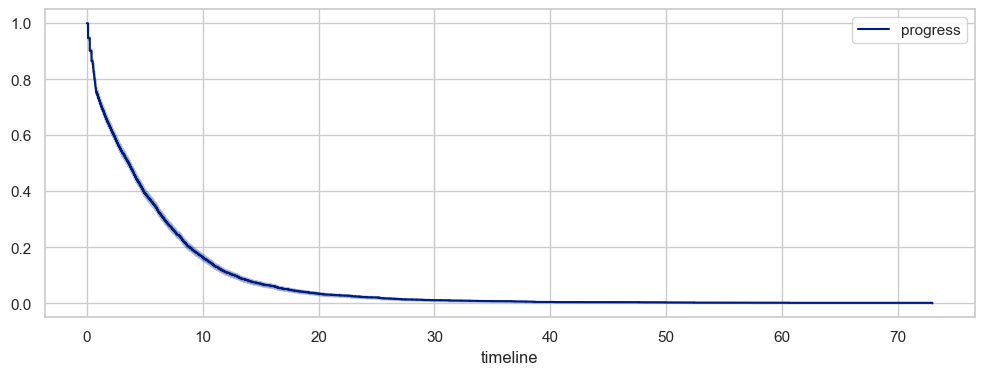

In [91]:
# View basic fitting
kmf = KaplanMeierFitter(label='progress')
kmf = kmf.fit(durations=model_df['progress'], event_observed=model_df['lst_event'])
kmf.plot(figsize=(12, 4))
plt.show()

In [92]:
median = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
median_confidence_interval_

,progress_lower_0.95,progress_upper_0.95
0.5,3.419998,3.789997


- Check if 'leverage' has influence on target variable

In [93]:
outer_leverage = model_df[model_df['leverage'] == 1]
inner_leverage = model_df[model_df['leverage'] == 0]

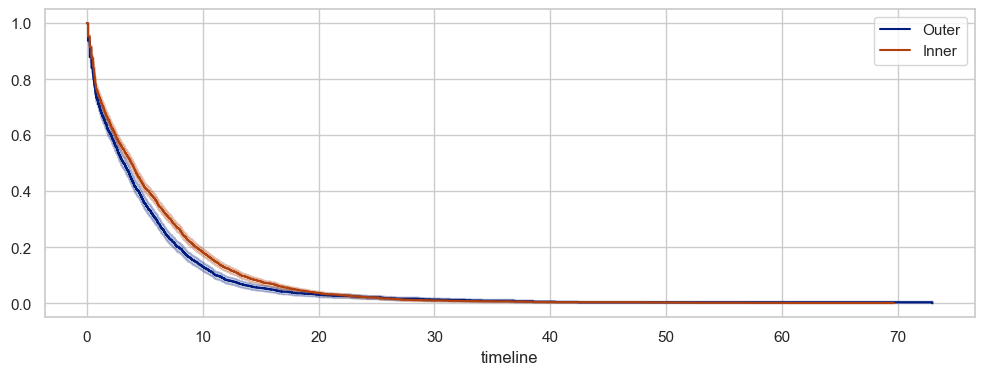

In [94]:
kmf_outer_leverage = KaplanMeierFitter(label='Outer').fit(
    durations=outer_leverage['progress'], event_observed=outer_leverage['lst_event'])
kmf_inner_leverage = KaplanMeierFitter(label='Inner').fit(
    durations=inner_leverage['progress'], event_observed=inner_leverage['lst_event'])

kmf_outer_leverage.plot(figsize=(12, 4))
kmf_inner_leverage.plot(figsize=(12, 4))

plt.show()

In [95]:
target_progress = 5
results = survival_difference_at_fixed_point_in_time_test(
    point_in_time=target_progress, fitterA = kmf_outer_leverage, fitterB = kmf_inner_leverage)
print('Chi-squared(1) Test statistic='+str(results.test_statistic) + ' p-value='+str(results.p_value))

Chi-squared(1) Test statistic=16.09041921360733 p-value=6.0388778629879436e-05


In [96]:
target_progress = 20
results = survival_difference_at_fixed_point_in_time_test(
    point_in_time=target_progress, fitterA = kmf_outer_leverage, fitterB = kmf_inner_leverage)
print('Chi-squared(1) Test statistic='+str(results.test_statistic) + ' p-value='+str(results.p_value))

Chi-squared(1) Test statistic=1.1664181712529813 p-value=0.2801384340118722


The tests above suggest that between the two leverage groups, there is a significant difference in their probabilities of survial at progress = 5, but there isn't a significant difference in their probabilities of survial at progress = 20.

## Fit Cox Proportional Hazards Model 

In [97]:
mask = np.random.rand(len(model_df)) < 0.8
df_train = model_df[mask]
df_test = model_df[~mask]

In [98]:
cph_model = CoxPHFitter()
cph_model.fit(df=df_train, duration_col='progress', event_col='lst_event')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 3997 total observations, 92 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
      baseline estimation = breslow
   number of observations = 3997
number of events observed = 3905
   partial log-likelihood = -27998.65
         time fit was run = 2024-01-05 19:44:31 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.15       0.86       0.01            -0.17            -0.13                 0.84                 0.88
near_dist          -0.16       0.85       0.01            -0.18            -0.14                 0.84                 0.87
caught_width       -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
leverage            0.01       1.01       0.03            -0.06             0.08                 0.95                 1.08

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -14.41 <0.005     153.94
near_dist             0.00 -19.18 <0.005     270.06
caught_width          0.00  -0.80   0.42       1.24
leverage              0.00   0.30   0.77       0.39
---
Concordance = 0.74
Partial AIC = 56005.29
log-likelihood ratio test = 1116.67 on 4 df
-log2(p) of ll-ratio test = 796.38

The model summary suggests that:
    
- Indicated by high '-log2(p)' value and low p-value, both 'near_defender_MPD' and 'near_dist' have a significant negative impact on the hazard (occurrence of a dead ball). Negative coef indicates that as the values of these two increase, the likelihood of the event happening decreases.   

- Leverage and caught_width do not show a statistically significant effect.

- The concordance index of 0.74 suggests the model has good yet not perfect predictive power. 

- the high overall -log2(p) suggests the overall model is statistically significant.

<Axes: xlabel='log(HR) (95% CI)'>

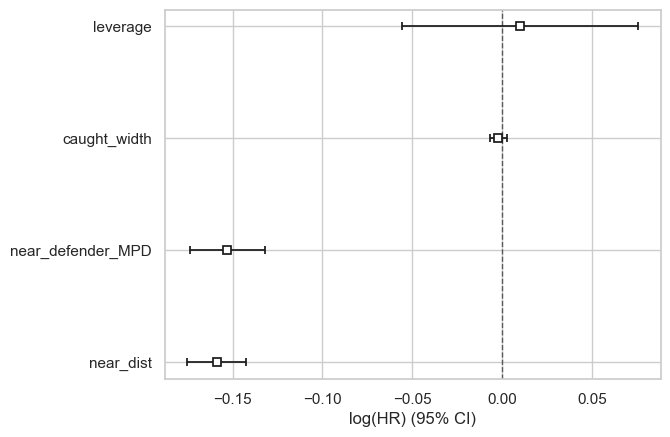

In [99]:
cph_model.plot()

- Check variable effects on survival curve

In [100]:
quartiles = model_df[['near_defender_MPD', 'near_dist', 'caught_width']].quantile([0.25, 0.50, 0.75])

In [101]:
quartiles

,near_defender_MPD,near_dist,caught_width
0.25,0.363336,1.580103,8.1575
0.50,0.764773,3.006302,13.3150
0.75,1.991656,4.950889,18.8200


<Figure size 1200x400 with 0 Axes>

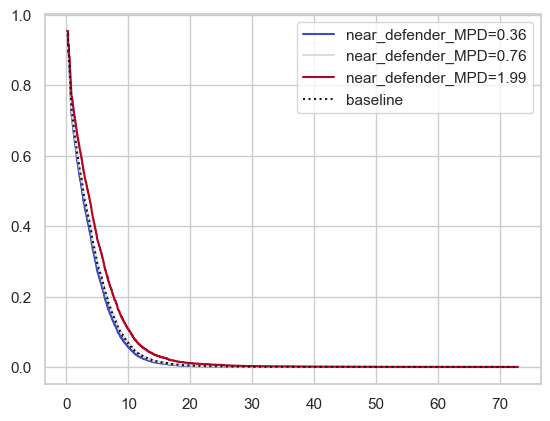

In [102]:
plt.figure(figsize=(12, 4))
cph_model.plot_partial_effects_on_outcome(
    covariates = 'near_defender_MPD', values = quartiles.near_defender_MPD.round(2).to_list(), cmap = 'coolwarm')
plt.show()

<Figure size 1200x400 with 0 Axes>

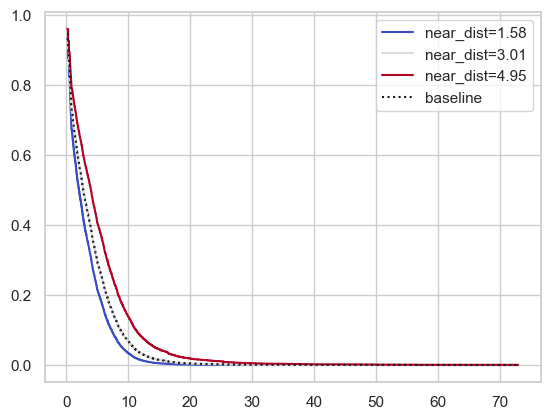

In [103]:
plt.figure(figsize=(12, 4))
cph_model.plot_partial_effects_on_outcome(
    covariates = 'near_dist', values = quartiles.near_dist.round(2).to_list(), cmap = 'coolwarm')
plt.show()

<Figure size 1200x400 with 0 Axes>

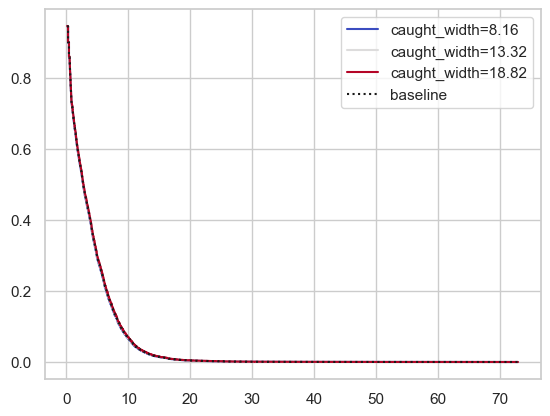

In [104]:
plt.figure(figsize=(12, 4))
cph_model.plot_partial_effects_on_outcome(
    covariates = 'caught_width', values = quartiles.caught_width.round(2).to_list(), cmap = 'coolwarm')
plt.show()

<Figure size 1200x400 with 0 Axes>

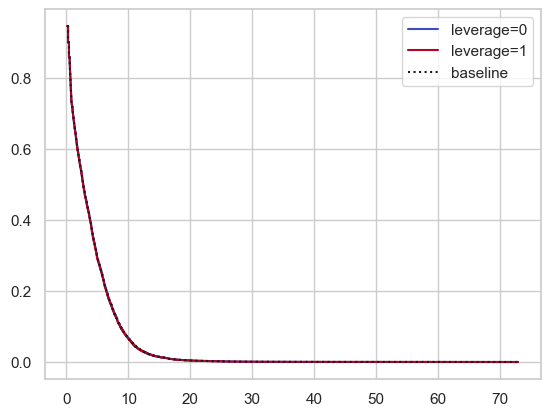

In [105]:
plt.figure(figsize=(12, 4))
cph_model.plot_partial_effects_on_outcome(
    covariates = 'leverage', values = [0,1], cmap = 'coolwarm')
plt.show()

In contrast to kmf model, the cph model doesn't recognize the significance of leverage's impact, thus I checked the covairance between all the variables

In [106]:
scaler = StandardScaler()
standardized_df = pd.DataFrame(scaler.fit_transform(model_df), columns = model_df.columns)

In [107]:
standardized_df.cov()

,progress,lst_event,near_defender_MPD,near_dist,caught_width,leverage
progress,1.000199,-0.141054,0.420661,0.428068,-0.005994,-0.058133
lst_event,-0.141054,1.000199,-0.049681,-0.020245,-0.010591,-0.004592
near_defender_MPD,0.420661,-0.049681,1.000199,0.511977,-0.020775,-0.060021
near_dist,0.428068,-0.020245,0.511977,1.000199,-0.005997,-0.058576
caught_width,-0.005994,-0.010591,-0.020775,-0.005997,1.000199,-0.007269
leverage,-0.058133,-0.004592,-0.060021,-0.058576,-0.007269,1.000199


The result suggests that :
- leverage and caught_width both have weak covariance with all variables
- features near_defender_MPD and near_dist have a positive covrariance close to 0.5
- target variable progress has a positive covrariance with near_defender_MPD and near_dist both close to 0.4